In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
import pickle
# from nltools.data import Brain_Data, Adjacency
# from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

from diffusers import MusicLDMPipeline, AudioPipelineOutput, StableAudioPipeline
# from diffusers import DiffusionPipeline, AudioPipelineOutput
from IPython.display import Audio


os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
BASE_PATH_LOAD = '*'

with open(BASE_PATH_LOAD + '/working_data_dict_vae' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)


def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict


# -----------------------------------------------------------------------------------------
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

# mask_path = "mask_to_save/mask_top_512_voxels.nii.gz"
mask_path = BASE_PATH_LOAD + "/mask_him_005.nii.gz"
# mask_path = "mask_01.nii.gz"
if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load(mask_path))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
       
if transform_masking:
    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")      

else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)


# -----------------------------------------------------------------------------------------
df_captions = pd.read_csv(BASE_PATH_LOAD + '/brain2music-captions.csv')
print(df_captions.head())
captions_array = df_captions.to_numpy()
caption_dict = {item[0].split('_')[0]: item[1] for item in captions_array}

for subj in subject_ids:

    train_stim_name_list = working_data_dict[subj]['train_stim_name']
    train_stim_caption_list = []

    for file_path in train_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        train_stim_caption_list.append(caption)

    working_data_dict[subj]['train_stim_caption'] = train_stim_caption_list


for subj in subject_ids:

    test_stim_name_list = working_data_dict[subj]['test_stim_name']
    test_stim_caption_list = []

    for file_path in test_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        test_stim_caption_list.append(caption)

    working_data_dict[subj]['test_stim_caption'] = test_stim_caption_list


# -----------------------------------------------------------------------------------------

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key, stim_caption_key, feat_vae_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    df['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for audio features
    features_avg = df_features.groupby('Stimulus').mean().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()

    # Handle genres (assuming genre data is aligned with stimuli names)
    df_caption = pd.DataFrame(data_dict[stim_caption_key], columns=['Caption'])
    df_caption['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    caption_avg = df_caption.groupby('Stimulus').first().reset_index()

    df_vae = pd.DataFrame(data_dict[feat_vae_key].reshape(data_dict[feat_vae_key].shape[0],-1), dtype=float)
    df_vae['Stimulus'] = data_dict[stim_name_key]
    
    vae_avg = df_vae.groupby('Stimulus').mean().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_caption_avg': caption_avg['Caption'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values,
        key_suffix + '_vae_avg': vae_avg.drop(columns='Stimulus').values
    }


working_data_dict_avg = {}
for sub in subject_ids:
    working_data_dict_avg[sub] = {}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg',
            'train_stim_caption',
            'train_audio_vae'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg',
            'test_stim_caption',
            'test_audio_vae'
        )
    )





In [3]:
train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)

X_train_aligned = np.concatenate([working_data_dict_avg[sub]["train_fmri_avg"] for sub in subject_ids],0)
X_test_aligned = np.concatenate([working_data_dict_avg[sub]["test_fmri_avg"] for sub in subject_ids],0)

train_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_vae_avg"] for sub in subject_ids],0)
test_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_vae_avg"] for sub in subject_ids],0)

In [4]:
subject_train_ids=[]
subject_test_ids=[]

for p in tqdm.tqdm(subject_ids):

    subject_train_ids+=[p]*len(working_data_dict_avg[p]["train_fmri_avg"])
    subject_test_ids+=[p]*len(working_data_dict_avg[p]["test_fmri_avg"])

100%|██████████| 5/5 [00:00<00:00, 90394.48it/s]


In [5]:
print(X_train_aligned.shape)
print(X_test_aligned.shape)
print(train_audio_feat_aligned.shape)
print(test_audio_feat_aligned.shape)
print(len(subject_train_ids))
print(len(subject_test_ids))

(2400, 3043)
(300, 3043)
(2400, 512)
(300, 512)
2400
300


In [6]:
print(X_train_aligned.mean())
print(train_audio_feat_aligned.mean())
print(X_train_aligned.std())
print(train_audio_feat_aligned.std())

0.0018652336098391941
-0.0005942661985135746
0.5223170936565312
0.044180970626801666


In [7]:
subject_train_ids = [int(i[-1]) for i in subject_train_ids]
subject_test_ids = [int(i[-1]) for i in subject_test_ids]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim,act_fn=nn.Identity,alignment_layers_keys=[1,2,5,7],common_dim=1024):
        super(Encoder, self).__init__()
        self.common_dim=common_dim
        self.alignment_layers={}
        for k in alignment_layers_keys:
            self.alignment_layers[k]=nn.Linear(input_dim, common_dim)      # Lazy
        
        layers = []
        prev_dim = input_dim
        # layers.append(nn.LayerNorm(common_dim))     # TODO: remove LayerNorm
        if len(hidden_dims):

            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(common_dim, hidden_dim))
                layers.append(act_fn())     # TODO: mettere identity
            layers.append(nn.Linear(hidden_dim, output_dim))
           
        else:
            layers.append(act_fn())
            layers.append(nn.Linear(common_dim, output_dim))
        self.net = nn.Sequential(*layers)   

        
    def _apply(self, fn):
        super(Encoder, self)._apply(fn)        
        for k,v in self.alignment_layers.items():
            self.alignment_layers[k]._apply(fn)
            
    
    def forward(self, x, k=None):
        
        def apply_alignment_layers(x, k, alignment_layers):
            # Create an empty tensor to store the results
            result = torch.empty_like(x)
            result = result[:,:self.common_dim]
            
            # Iterate through each unique key in k
            for key in k.unique():
                # Create a mask for all elements that match the current key
                mask = (k == key.item())
                
                # Apply the corresponding alignment layer to the masked elements
                result[mask] = alignment_layers[key.item()](x[mask])
            
            return result
        
        if k is None:
            k=torch.ones(len(x))
        # Apply alignment layers to x using the custom function
        x = apply_alignment_layers(x, k, self.alignment_layers)
        # x = self.alignment_layers[k](x)
        return self.net(x)
    

# Funzione per calcolare la similarità coseno
def cosine_similarity_matrix(A, B):
    A_norm = F.normalize(A, dim=1)
    B_norm = F.normalize(B, dim=1)
    return torch.mm(A_norm, B_norm.T)

# NT-Xent Loss (Contrastive)
def contrastive_loss_nt(S, tau):
    S_exp = torch.exp(S / tau)
    loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
    return loss.mean()

def contrastive_loss(z_i, z_j, tau):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    logits = (z_i @ z_j.T) / tau
    similarities = z_j @ z_j.T
    # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)
    targets = torch.arange(logits.shape[0]).long().to(logits.device)
    loss = torch.nn.functional.cross_entropy(logits, targets)
    return loss

tau = 0.10

class ContrastiveOTModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, output_dim, common_dim=1024, alignment_layers_keys=[1,2,5,7]):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dims, output_dim, alignment_layers_keys=alignment_layers_keys, common_dim=common_dim)
        self.dropout = nn.Dropout(p=0.5)    
        self.tau = tau

        self.train_losses = []
        self.train_contrastive_loss=[]
        self.val_losses = []
        self.val_contrastive_loss=[]
    
        self.train_history={}
        self.val_history={}

        self.train_history["train_loss"]=[]
        self.train_history["train_contrastive_loss"]=[]
        self.val_history["val_loss"]=[]
        self.val_history["val_contrastive_loss"]=[]

    def forward(self, x, **kwargs):
        return self.encoder(x, **kwargs)

    def loss_fn(self, x_latent, y_latent):
        S = cosine_similarity_matrix(x_latent, y_latent)
        contrastive_loss_value = contrastive_loss_nt(S, self.tau) 
        return contrastive_loss_value, contrastive_loss_value
    
    def compute_loss(self, x, y, idx):
        x_latent = self(x, k=idx)
        y_latent = y  
        return self.loss_fn(x_latent, y_latent)

    def training_step(self, batch, batch_idx):
        x, y, idx = batch  
        loss, contrastive_loss_value = self.compute_loss(x, y, idx)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.train_losses.append(loss.item())
        self.train_contrastive_loss.append(contrastive_loss_value.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, idx = batch
        loss, contrastive_loss_value = self.compute_loss(x, y, idx)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.val_losses.append(loss.item())
        self.val_contrastive_loss.append(contrastive_loss_value.item())
        return loss
    
    def on_train_epoch_end(self) -> None:
        self.train_history["train_loss"].append(np.mean(self.train_losses))
        self.train_history["train_contrastive_loss"].append(np.mean(self.train_contrastive_loss))
        self.train_losses = []
        self.train_contrastive_loss=[]
        return super().on_train_epoch_end()
    
    def on_validation_epoch_end(self) -> None:
        self.val_history["val_loss"].append(np.mean(self.val_losses))
        self.val_history["val_contrastive_loss"].append(np.mean(self.val_contrastive_loss))
        self.val_losses = []
        self.val_contrastive_loss=[]
        return super().on_validation_epoch_end()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, threshold=0.05, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [26]:
from torch.utils.data import Dataset, DataLoader

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_aligned).float(),torch.tensor(train_audio_feat_aligned).squeeze(1).float(), torch.tensor(subject_train_ids))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_aligned).float(),torch.tensor(test_audio_feat_aligned).squeeze(1).float(), torch.tensor(subject_test_ids))

x, y, idx = train_dataset[0]  
BS = 512 
BS_test = int(BS/2) 

clip_train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_test_dataloader = DataLoader(test_dataset, batch_size=BS_test, shuffle=False)

x, y, idx = next(iter(clip_train_dataloader))
print(x.shape, y.shape)

torch.Size([512, 3043]) torch.Size([512, 512])


In [ ]:
pl.seed_everything(55, workers=True)      # 55, 999, 42, 1

# Configurazione PyTorch Lightning
brain_model = ContrastiveOTModel(input_dim=X_train_aligned.shape[-1], hidden_dims=[512],       # 512 valore migliore
                                 output_dim=512, common_dim=3043, alignment_layers_keys=[1,2,3,4,5])

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=9, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=100, devices=[2], callbacks=[early_stop_callback])
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)


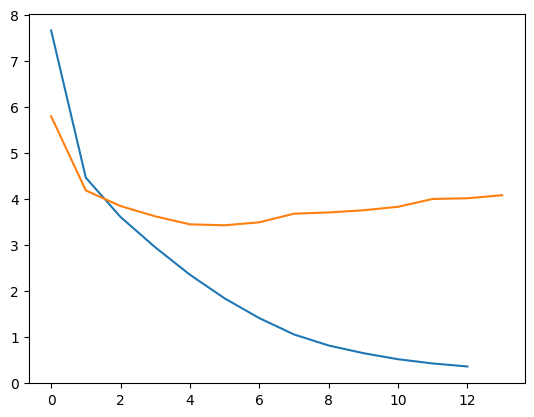

In [30]:
plt.plot(brain_model.train_history["train_contrastive_loss"], label='train')
plt.plot(brain_model.val_history["val_contrastive_loss"], label='val')

In [31]:
device='cuda:2'
x,y,k=next(iter(clip_test_dataloader))

y_pred=[]
y_true=[]
with torch.no_grad():
    for x,y,k in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x,k=k).to(device)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)

100%|██████████| 2/2 [00:00<00:00, 81.89it/s]


In [32]:
y_pred.shape, y_true.shape

(torch.Size([300, 512]), torch.Size([300, 512]))

In [33]:
y_pred.mean(), y_true.mean(), y_pred.std(), y_true.std()

(tensor(0.0019, device='cuda:2'),
 tensor(-0.0004),
 tensor(0.1043, device='cuda:2'),
 tensor(0.0433))

In [ ]:
from sklearn.neighbors import NearestNeighbors

samples_per_subject = 60  
top1_count_list = []
top3_count_list = []

# subject_idx = 1
for subject_idx in range(4):
    start_idx = subject_idx * samples_per_subject
    end_idx = (subject_idx + 1) * samples_per_subject

    y_true_np = y_true[start_idx:end_idx].cpu().numpy()
    y_pred_np = y_pred[start_idx:end_idx].cpu().numpy()
    nbrs = NearestNeighbors(n_neighbors=3, metric='cosine').fit(y_true[0:samples_per_subject].cpu().numpy())

    distances, top_indices = nbrs.kneighbors(y_pred_np)
    true_indices = torch.arange(len(y_true_np)).cpu().numpy()

    # Calcoliamo il numero di volte in cui il candidato stimato è nella top-1 e top-3
    top1_count = (top_indices[:, 0] == true_indices).sum()
    top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

    print(f"Soggetto {subject_idx + 1}:")
    print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
    print(f"Top-3 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

    top1_count_list.append(top1_count)
    top3_count_list.append(top3_count)

print("---------------------------")
print("Top-1 accuracy:", sum(top1_count_list) / len(y_true) * 100)
print("Top-3 accuracy:", sum(top3_count_list) / len(y_true) * 100)

## Ridge

In [20]:
X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
train_audio_feat_torch = torch.tensor(train_audio_feat_aligned, dtype=torch.float32).to(device)

# Modello Ridge per mappare brain activity → latent space
brain_to_latent = Ridge(alpha=20)
brain_to_latent.fit(X_train, train_audio_feat_aligned)
audio_feat_pred_test = brain_to_latent.predict(X_test)
audio_feat_pred_test_torch = torch.tensor(audio_feat_pred_test, dtype=torch.float32).to(device)

In [21]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

# vm = RidgeCV(alphas=[20], fit_intercept=True) 
vm = RidgeCV(alphas=[20])  
device_id = 2
backend = set_backend("torch_cuda")
X_train_sbj = backend.asarray(torch.tensor(X_train, dtype=torch.float32).to(f'cuda:{device_id}'))
Y_train_sbj = backend.asarray(torch.tensor(train_audio_feat_aligned, dtype=torch.float32).to(f'cuda:{device_id}')) 
X_test_sbj = backend.asarray(torch.tensor(X_test, dtype=torch.float32).to(f'cuda:{device_id}'))     

vm.fit(X_train_sbj, Y_train_sbj)
y_pred_sbj = vm.predict(X_test_sbj)

In [22]:
y_pred_sbj.shape

torch.Size([300, 512])

In [ ]:
subject_idx = 1
start_idx = subject_idx * samples_per_subject
end_idx = (subject_idx + 1) * samples_per_subject

y_true_base = test_audio_feat_aligned[start_idx:end_idx]
y_pred_base = y_pred_sbj[start_idx:end_idx]
nbrs_base = NearestNeighbors(n_neighbors=3, metric='cosine').fit(y_true_base[0:samples_per_subject])

distances, top_indices_base = nbrs_base.kneighbors(y_pred_base)
true_indices_base = torch.arange(len(y_true_base)).cpu().numpy()

# Calcoliamo il numero di volte in cui il candidato stimato è nella top-1 e top-3
top1_count_base = (top_indices_base[:, 0] == true_indices_base).sum()
top3_count_base = sum(true_idx in top_indices_base[i] for i, true_idx in enumerate(true_indices_base))

print(f"Soggetto {subject_idx + 1}:")
print(f"Top-1 accuracy: {top1_count_base}/{len(y_true_base)} ({top1_count_base / len(y_true_base) * 100:.2f}%)")
print(f"Top-3 accuracy: {top3_count_base}/{len(y_true_base)} ({top3_count_base / len(y_true_base) * 100:.2f}%)")

## Linear VS Non Linear

In [ ]:
# np.save("*", y_pred.cpu().numpy())
y_pred_mlp = np.load("*/y_pred_mlp_gtzan.npy")

Paired t-test: t = 8.562745154727587, p = 2.9552845609492437e-16
Cohen's d: 0.495


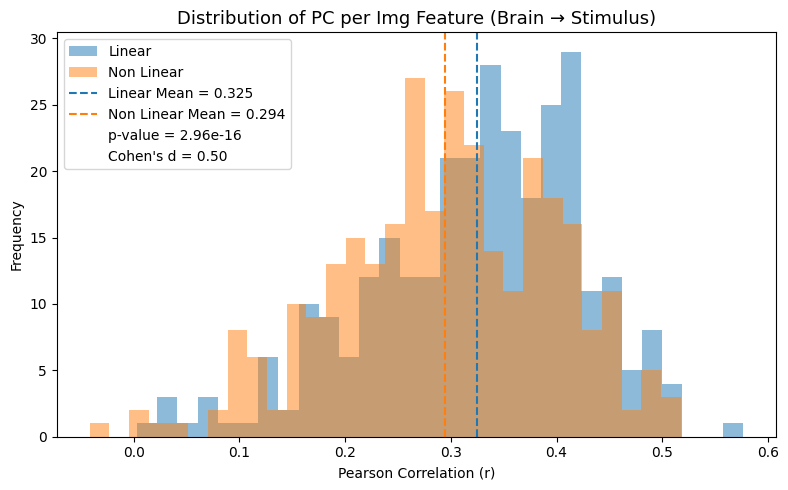

In [ ]:
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D

# y_true = y_true
y_pred_linear = y_pred.cpu().numpy()
# y_pred_mlp = y_pred_mlp

def get_corrs(y_true, y_pred):
    return [np.corrcoef(y_true[i, :], y_pred[i, :])[0, 1] for i in range(y_true.shape[0])]

corr_linear = get_corrs(y_true, y_pred_linear)
corr_mlp = get_corrs(y_true, y_pred_mlp)

mean_linear = np.mean(corr_linear)
mean_mlp = np.mean(corr_mlp)

t_stat, p_val = ttest_rel(corr_linear, corr_mlp, alternative='greater')
print(f"Paired t-test: t = {t_stat}, p = {p_val}")

diff = np.array(corr_linear) - np.array(corr_mlp)
cohens_d = diff.mean() / diff.std()
print(f"Cohen's d: {cohens_d:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(corr_linear, bins=30, alpha=0.5, label='Linear', color='tab:blue')
plt.hist(corr_mlp, bins=30, alpha=0.5, label='Non Linear', color='tab:orange')
plt.axvline(mean_linear, color='tab:blue', linestyle='--', label=f'Linear Mean = {mean_linear:.3f}')
plt.axvline(mean_mlp, color='tab:orange', linestyle='--', label=f'Non Linear Mean = {mean_mlp:.3f}')

plt.title("Distribution of PC per Img Feature (Brain → Stimulus)", fontsize=13)
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("Frequency")

stat_legend = [
    Line2D([0], [0], color='none', label=f'p-value = {p_val:.2e}'),
    Line2D([0], [0], color='none', label=f"Cohen's d = {cohens_d:.2f}")
]

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + stat_legend, labels + [h.get_label() for h in stat_legend])

plt.grid(False)
plt.tight_layout()
plt.show()



## Similarity Comparison

In [184]:
from sklearn.preprocessing import StandardScaler

def compute_cosine_matrix(real_embeddings, predicted_embeddings):

    real_embeddings = torch.tensor(real_embeddings, dtype=torch.float32)
    predicted_embeddings = torch.tensor(real_embeddings, dtype=torch.float32)
    real_embeddings = torch.nn.functional.normalize(real_embeddings, dim=1)
    predicted_embeddings = torch.nn.functional.normalize(predicted_embeddings, dim=1)
    similarity_matrix = torch.mm(real_embeddings, predicted_embeddings.T)  # Matrice (num_real x num_pred)
    
    return similarity_matrix.numpy()


def compute_normalized_similarities(y_pred, y_gt):
    # Normalize by L2 norm
    y_pred = torch.tensor(y_pred, dtype=torch.float32)
    y_gt = torch.tensor(y_gt, dtype=torch.float32)
    y_pred_norm = torch.nn.functional.normalize(y_pred, dim=1)
    y_gt_norm = torch.nn.functional.normalize(y_gt, dim=1)

    # Compute similarity
    sims = y_pred_norm @ y_gt_norm.T

    # Normalize similarities
    scaler = StandardScaler()
    sims_z = scaler.fit_transform(sims.cpu().numpy())

    return sims, sims_z

In [ ]:
feat_ridge_list = []
feat_otcl_list = []
feat_true_list = []

for sub_i in range(3):

    start_idx = sub_i * samples_per_subject
    end_idx = (sub_i + 1) * samples_per_subject
    feat_ridge_list.append(y_pred_sbj.float().cpu()[start_idx:end_idx])
    feat_otcl_list.append(y_pred.cpu()[start_idx:end_idx])
    feat_true_list.append(y_true.cpu()[start_idx:end_idx])

feat_ridge_subj = np.stack(feat_ridge_list, axis=0).mean(axis=0)
feat_true_subj = np.stack(feat_true_list, axis=0).mean(axis=0)
feat_otcl_subj = np.stack(feat_otcl_list, axis=0).mean(axis=0)

In [187]:
similarity_matrix_ot, _ = compute_normalized_similarities(feat_otcl_subj, feat_true_subj)
similarity_matrix, _ = compute_normalized_similarities(feat_ridge_subj, feat_true_subj)

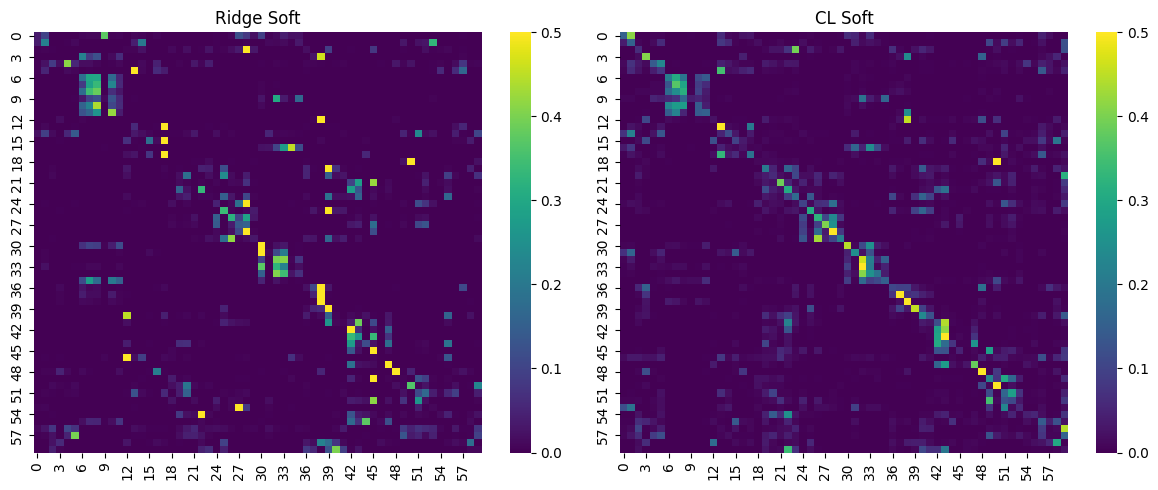

In [189]:
import torch
import torch.nn.functional as F
import seaborn as sns

sims_otcl_soft = F.softmax(torch.tensor(similarity_matrix_ot)/0.05, dim=1)
sims_ridge_soft = F.softmax(torch.tensor(similarity_matrix)/0.05, dim=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

sns.heatmap(sims_ridge_soft, cmap='viridis', vmin=0, vmax=0.5, ax=axes[0])
axes[0].set_title("Ridge Soft")
sns.heatmap(sims_otcl_soft, cmap='viridis', vmin=0, vmax=0.5, ax=axes[1])
axes[1].set_title("CL Soft")

plt.tight_layout()
plt.show()